
## Subtask 1: Text Summarization (4 Marks)
- Use a pretrained model like facebook/bart-large-cnn or t5-small.
- Fine-tune the model on a custom dataset (e.g., scientific abstracts, news articles).
- Evaluate the model using the ROUGE score.
- Generate summaries for 5 test samples.

In [1]:
!pip install datasets
!pip install rouge-score
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [2]:
from transformers import BartForConditionalGeneration, BartTokenizer
#FF: Bidirectional and Auto-Regressive Transformer
from datasets import load_dataset, Dataset
from rouge_score import rouge_scorer #FF: Recall-Oriented Understudy for Gisting Evaluation

In [2]:
# Load the BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name) # tokenize raw text to model compatible
model = BartForConditionalGeneration.from_pretrained(model_name) # pretrained BART for summary stuff

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from datasets import load_dataset

# Load news article w summary
dataset = load_dataset("cnn_dailymail", "3.0.0")
dataset['train'][:1]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
train_sample = dataset['train'].select(range(800))
vali_sample=dataset['validation'].select(range(200))

In [6]:
train_sample[0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [7]:
from transformers import BartTokenizer

# Load tokenizer
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Tokenization function
def preprocess_function(examples):
    # tokenize ip+op w padding and truncate
    # (has internal attention mask to know which token are real and paddinh)
    inputs = tokenizer(examples['article'], max_length=512, truncation=True, padding="max_length")
    outputs = tokenizer(examples['highlights'], max_length=150, truncation=True, padding="max_length")
    inputs['labels'] = outputs['input_ids'] # to used tokenized highlights as label
    return inputs


tokenized_sample_train = train_sample.map(preprocess_function, batched=True)
tokenized_sample_val= vali_sample.map(preprocess_function, batched=True)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [8]:
tokenized_sample_train[:1]

{'article': ['LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

In [9]:
from transformers import BartForConditionalGeneration, Trainer, TrainingArguments

# Load model
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./temp", ## save model chkpts
    evaluation_strategy="epoch", ## eval at epoch end
    learning_rate=2e-5, ## 2* 10^-5
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01, # wt reg to avoid overfitting
    save_strategy="no",
    logging_dir="./logs", ## save train log
    report_to="none",
    logging_steps=10 ## log every 10 step
)


# Initialize Trainer
trainer = Trainer(
    model=model, ## pretrained bart
    args=training_args,
    train_dataset=tokenized_sample_train, #train
    eval_dataset=tokenized_sample_val ## validt
)

# Start fine tuning BArt using CNN dataset
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.570000,0.532359
2,0.359500,0.571584
3,0.261900,0.621848


TrainOutput(global_step=600, training_loss=0.5498789207140604, metrics={'train_runtime': 715.2211, 'train_samples_per_second': 3.356, 'train_steps_per_second': 0.839, 'total_flos': 2600525522534400.0, 'train_loss': 0.5498789207140604, 'epoch': 3.0})

In [10]:
model.save_pretrained("/content/temp")
tokenizer.save_pretrained("/content/temp")

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('/content/temp/tokenizer_config.json',
 '/content/temp/special_tokens_map.json',
 '/content/temp/vocab.json',
 '/content/temp/merges.txt',
 '/content/temp/added_tokens.json')

In [11]:
from transformers import BartForConditionalGeneration, BartTokenizer
from evaluate import load

rouge = load("rouge")
# Load tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn") # std BART token
model = BartForConditionalGeneration.from_pretrained("/content/temp") # fine tuned BART model
# Select 5 test samples
test_samples = dataset['validation'].select(range(5))

# Function to generate summaries
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    ## pt= pytorch

    summary_ids = model.generate(
        inputs['input_ids'],
        max_length=150,
        min_length=40,
        num_beams=4, # 4 probable beam during prediction beam search
        early_stopping=True
    )

    # Decode the generated text
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True) ## remove special tokens


generated_summaries = []
reference_summaries = []

for sample in test_samples:
    generated_summary = generate_summary(sample['article'])
    generated_summaries.append(generated_summary) # model generated
    reference_summaries.append(sample['highlights']) # ground truth

    print(f"\nArticle:\n{sample['article']}")
    print(f"\nGenerated Summary:\n{generated_summary}")
    print(f"\nGround Truth Summary:\n{sample['highlights']}")
    print("_" * 100)

# Compute ROUGE score
rouge_score = rouge.compute(predictions=generated_summaries, references=reference_summaries)

print("ROUGE Scores:")
# Access the F1-score directly from the rouge_score dictionary
for key, value in rouge_score.items():
    print(f"{key}: {value:.4f}")  # Directly access the F1-score (value)

/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1532: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Article:
(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacific Medica

## ROUGE Scores:
- rouge1: 0.1538 (15.38% unigram overlap between generated and Ground truth)
- rouge2: 0.0483 (4.83% bigram overlap between generated and Ground truth)
- rougeL: 0.1109 (11.09% of longest subsequence  are preserved between generated and ground truth)
- rougeLsum: 0.1483 (14.83% sentence structure similarity)


## Subtask 2: Named Entity Recognition (NER) (3 Marks)
- Use a pretrained NER model, such as bert-base-cased-finetuned-conll03-english.
- Fine-tune the model on a custom dataset (e.g., CoNLL-2003 or custom annotated text).
- Extract entities like PERSON, LOCATION, and ORGANIZATION from the text.
- Report F1 score and accuracy on the test set

In [15]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np
import torch

In [20]:
def create_ner_pipeline(model, tokenizer):
    return pipeline("ner", model=model, tokenizer=tokenizer)

id2label = model.config.id2label # assign numeric id to entity label, like per = 0
ner_pipeline = create_ner_pipeline(model, tokenizer)

Device set to use cuda:0


In [30]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
from transformers import DataCollatorForTokenClassification
import numpy as np
from evaluate import load
import torch

# Load the pretrained BERT model for NER
model_name = "dbmdz/bert-base-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name) # tokenizes according to pretrained param
model = AutoModelForTokenClassification.from_pretrained(model_name) # load BERT NER

Some weights of the model checkpoint at dbmdz/bert-base-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
dataset = load_dataset("conll2003")

# Select a smaller subset for training, validation, and testing
train_sample = dataset['train'].select(range(800))
vali_sample = dataset['validation'].select(range(200))
test_sample = dataset['test'].select(range(50))

In [32]:
label_list = dataset['train'].features['ner_tags'].feature.names ##


In [52]:
label_list
## B- beginning of entity
## I - inside entity

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [ ]:
entity_labels = {"B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG"}  # consider relevant Entity classes

In [33]:
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True,
                                 is_split_into_words=True, ## cuz ip is list
                                 padding="max_length",
                                 max_length=128)

    # Align labels with subwords
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map subword to originalwords
        previous_word = None
        label_ids = []
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore padding tokens...ignored during loss calc
            elif word_id != previous_word:
                label_ids.append(label[word_id])
            else:
                label_ids.append(-100)  # Ignore subword tokens
            previous_word = word_id
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize the dataset
tokenized_train = train_sample.map(preprocess_function, batched=True)
tokenized_vali = vali_sample.map(preprocess_function, batched=True)
tokenized_test = test_sample.map(preprocess_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [34]:
metric = load("seqeval")

In [39]:
def compute_metrics(p):
    predictions, labels = p # models raw op shape(batch,seq_len,num_label), ground truth
    predictions = np.argmax(predictions, axis=2) # save classes w highest prob

    # Convert id back to entity names
    true_predictions = [[label_list[p] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    # Extract overall F1-score and accuracy
    f1_score = results.get("overall_f1", 0.0)
    accuracy = results.get("overall_accuracy", 0.0)

    return {"f1": f1_score, "accuracy": accuracy}

In [43]:
trainer = Trainer(
    model=model, # ner
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_vali,
    tokenizer=tokenizer,
    data_collator=data_collator, # for batch activities
    compute_metrics=compute_metrics # for eval
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")

<ipython-input-43-5a5b0807b822>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.053080,0.927136,0.988421
2,No log,0.048082,0.925972,0.988036
3,No log,0.046672,0.933333,0.989193


('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/vocab.txt',
 './ner_model/added_tokens.json',
 './ner_model/tokenizer.json')

In [46]:
## Evaluation on test data
results = trainer.evaluate(tokenized_test)
print(f"F1 Score: {results['eval_f1']:.4f}")
print(f"Accuracy: {results['eval_accuracy']:.4f}")

F1 Score: 0.9116
Accuracy: 0.9834


In [50]:
import torch

## to ensure model and ip tensor are same cuda object type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_entities(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Move ip to same device as  model, ie GPU or CPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get predictions...reduce memory usage w/o gradient computation
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits # raw model op(unnormalised)
    predictions = torch.argmax(logits, dim=2) #  idx of the highest pred class

    # Decode token labels
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()) #tok-> wd
    predicted_labels = [label_list[pred] for pred in predictions[0].tolist()] #lbl-> entity class

    # Extract named entities
    entities = []
    current_entity = None
    current_label = None
    # to group multi word entity like New York , ie B-/I-LOC types
    for token, label in zip(tokens, predicted_labels):
        if label.startswith("B-"):  # Beginning of an entity
            if current_entity:
                entities.append((current_entity, current_label))
            current_entity = token
            current_label = label[2:]  # Remove "B-"
        elif label.startswith("I-") and current_entity:  # Inside an entity
            current_entity += " " + token
        else:  # No entity or end of entity
            if current_entity:
                entities.append((current_entity, current_label))
                current_entity = None
                current_label = None

    # If there's an entity left at the end
    if current_entity:
        entities.append((current_entity, current_label))

    return entities

# Test Named Entity Extraction
for sample in test_sample.select(range(2,7)):
    text = " ".join(sample['tokens'])
    entities = extract_entities(text)

    print("\n===== Extracted Named Entities =====")
    print(f"Text:\n{text}\n")
    print(f"Entities:\n{entities}\n")
    print("_" * 100)



===== Extracted Named Entities =====
Text:
AL-AIN , United Arab Emirates 1996-12-06

Entities:
[('AL - AI ##N', 'ORG'), ('United Arab Emirates', 'LOC'), ('[SEP]', 'LOC')]

____________________________________________________________________________________________________

===== Extracted Named Entities =====
Text:
Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .

Entities:
[('Japan', 'LOC'), ('Asian Cup', 'MISC'), ('Syria', 'LOC'), ('Group C', 'MISC')]

____________________________________________________________________________________________________

===== Extracted Named Entities =====
Text:
But China saw their luck desert them in the second match of the group , crashing to a surprise 2-0 defeat to newcomers Uzbekistan .

Entities:
[('China', 'LOC'), ('Uzbekistan', 'LOC')]

____________________________________________________________________________________________________

===== Extracted Named Entiti

In [7]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=6885fb391021ce8c2de32bd536b885e138ec3e0e6b779ea98f79f2125753f440
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


## Q2

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define input: Random 5x5 token embeddings
embed_dim = 5  # Each token has a 5-dim embedding
tokens = np.random.randn(5, embed_dim).astype(np.float32)  # 5 token each of dim 5

In [55]:
tokens

array([[ 0.49671414, -0.1382643 ,  0.64768857,  1.5230298 , -0.23415338],
       [-0.23413695,  1.5792128 ,  0.7674347 , -0.46947438,  0.54256004],
       [-0.46341768, -0.46572974,  0.24196227, -1.9132802 , -1.7249179 ],
       [-0.5622875 , -1.0128311 ,  0.31424734, -0.9080241 , -1.4123037 ],
       [ 1.4656488 , -0.2257763 ,  0.0675282 , -1.4247482 , -0.54438275]],
      dtype=float32)

In [56]:
# Define weight mtx using Dense layers
W_q = layers.Dense(embed_dim, use_bias=False)
W_k = layers.Dense(embed_dim, use_bias=False)
W_v = layers.Dense(embed_dim, use_bias=False)

# Compute Q, K, V mtx ... 5x5
Q = W_q(tokens)  #Q mtx
K = W_k(tokens)  # K mtx
V = W_v(tokens)  #V mtx

# Compute attention scores (scaled dot-product)
dim_k = tf.cast(embed_dim, dtype=tf.float32)  # convert dim(K) to float...getting type errors
scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(dim_k)  # QK^T/ sqrt(dim_K)

scores

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[-1.076371  , -0.38592535,  2.1014698 ,  1.4489138 ,  1.0709164 ],
       [ 1.0993285 ,  0.6734338 , -2.3071718 , -1.6221192 , -1.4699347 ],
       [ 0.20905033, -0.12700835, -0.38016424, -0.22806908,  0.14724958],
       [ 0.07219978, -0.3060218 ,  0.6696123 ,  0.58527184,  0.3462402 ],
       [-0.4063193 ,  0.02539074, -0.7038689 , -0.63605857,  0.55399626]],
      dtype=float32)>

In [57]:

# Apply softmax to get attention weights..ie probab scores
attention_weights = tf.nn.softmax(scores, axis=-1) ## row sum = 1...

# Compute final attention output
output = tf.matmul(attention_weights, V)  # aw * V

# Print matrices
print("Query:\n", Q.numpy())
print("Key:\n", K.numpy())
print("Value:\n", V.numpy())
print("Attention Weights:\n", attention_weights.numpy())
print("Final Attention Output:\n", output.numpy())



Query:
 [[ 0.6225629  -1.290991   -0.44648784  0.43115512 -1.5031633 ]
 [-0.83079517  1.6707504   0.36577678 -0.35023236  1.0939939 ]
 [-0.07401597  0.0200299   0.31740534  0.2409935   0.5340631 ]
 [-0.11449242 -0.9904898   0.39482605  0.0557625  -0.01290786]
 [ 0.5202949   0.9676653   0.17272815  1.1791387  -0.34969175]]
Key:
 [[-1.0177598   0.34700233  1.089028   -0.65600944  0.3699947 ]
 [-0.8635712   0.7438575  -0.08924112 -0.31214696 -0.48545897]
 [ 0.44652677 -2.0677922  -1.3092692   0.13845932 -0.7366245 ]
 [ 0.08226311 -1.6433415  -0.81183237  0.09402144 -0.44180512]
 [ 1.9748988  -1.0219904  -0.18236285  1.1924989   0.498823  ]]
Value:
 [[-4.4113427e-01 -4.4094384e-02  2.9155292e-02  1.4014366e-01
   1.5993465e-01]
 [ 6.6144747e-01 -4.0402180e-01 -6.4831960e-01 -4.8540628e-01
  -1.1213074e+00]
 [ 2.1511185e-01 -7.3944223e-01  8.1540942e-01  1.8162060e+00
   1.4601696e+00]
 [-5.1306522e-01 -2.1716344e-01  7.9561484e-01  1.9547346e+00
   1.5955292e+00]
 [ 1.1457924e+00 -1.956719

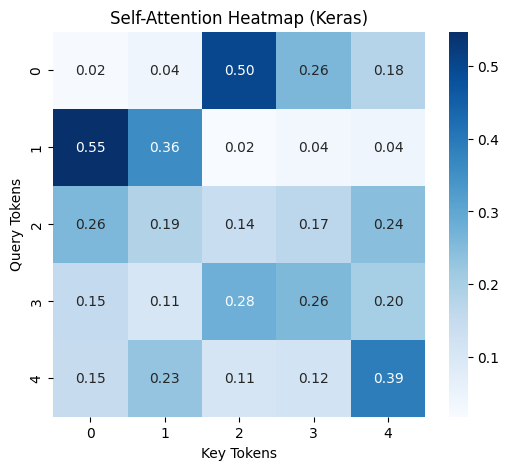

In [58]:
# Visualize attention scores as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attention_weights.numpy(), annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title("Self-Attention Heatmap (Keras)")
plt.show()